# Third model: feature extraction with data augmentation

This notebook describes how to create a CNN for classifying dogs and cats using feature extraction and data augmentation. Here, we use a pretrained CNN (VGG16) as a convolutional base, and add a few more layers on top of the convolutional base. Then, we train the resulting model using data augmentation.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint

In [2]:
def load_rcparams(figsize=None):
    """
    Load a custom rcParams dictionary
    """
    
    rcParams['axes.titlesize']  = 14            # title
    rcParams['axes.labelsize']  = 10            # $f_i$ labels
    rcParams['xtick.color']     = "#474747"     # ticks gray color
    rcParams['ytick.color']     = "#474747"     # ticks gray color
    rcParams['xtick.labelsize'] = 10            # ticks size
    rcParams['ytick.labelsize'] = 10            # ticks size
    rcParams['legend.fontsize'] = 12            # legend
    rcParams['legend.fontsize'] = 12            # legend

    if isinstance(figsize, tuple):
        rcParams['figure.figsize'] = figsize

In [3]:
base_dir = "/media/data/dogs_vs_cats_small"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

In [15]:
# load convolutional base
conv_base = VGG16(
            weights="imagenet",
            include_top=False,           # include or not the densely connected classifier on top of the network
            input_shape=(150, 150, 3)    # shape of the image tensors that you will feed to the network
            )

Because models behave just like layers, we can add a model (i.e., `conv_base`) to a `Sequential` model as follows:

In [7]:
# Listing 5.20 Adding a densely connected classifier on top of the convolutional base
model = models.Sequential()

model.add(conv_base)

# feature map shape: 
model.add(layers.Flatten())                            

# classifier
model.add(layers.Dense(256, activation="relu"))        # 256 hidden neurons
model.add(layers.Dense(1, activation="sigmoid"))       # 1 neuron

In [8]:
# check model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


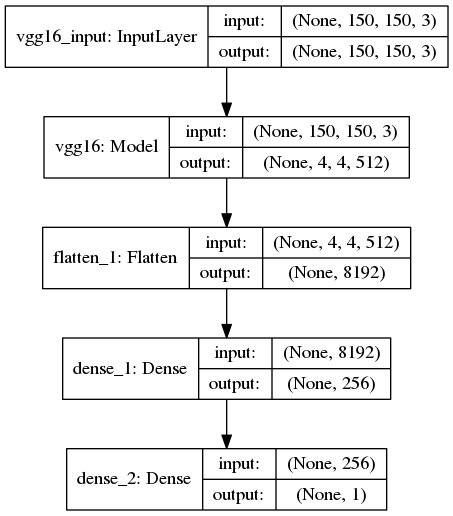

In [10]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

Before you compile and train the model, it is very important to freeze the convolutional base. **Freezing** a layer or set of layers means preveting they weights from being updated (changed) during training. If you do not do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the `Dense` layers on top are randomly initialized, very large weight updates would be propagated through the network, destroying the representations previously learned.

We can freeze the layers of `conv_base` as follows:

```
conv_base.trainable = False
```


In [18]:
print("This is the number of trainable weights before freezing the conv base:", len(model.trainable_weights))

# freeze layers
conv_base.trainable = False

print("This is the number of trainable weights after freezing the conv base:  ", len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base:   4


-----

**Note** It is important to freeze the layers before compiling the model. Otherwise, all the weights will be changed.

-----


According to the author:

> That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector)

The classifier added to top of `conv_base` has two layers, so there are 4 trainable weights. On the other hand, `conv_base` comprises 26 trainable weights. Just for completeness, let's check `conv_base`:

In [19]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The first layer (`input_2`) and pooling layers (`MaxPooling2D`) does not involve weights. As it can be see, there are 13 `Conv2D` layers, meaning that there are 26 trainable weights, as shown above (26 = 30 - 4).

Now, we can start training the model using data-augmentation.

In [10]:
# Listing 5.21 Training the model end to end with frozen convolutional base
train_datagen = ImageDataGenerator(
                    rescale=1./255,             # we multiply the data by the value provided (after applying all other transformations)
                    rotation_range=40,          # int, degree range for random rotations
                    width_shift_range=0.2,      # float, fraction of total width (other types are also available)
                    height_shift_range=0.2,     # float, fraction of total width (other types are also available)
                    shear_range=0.2,            # float, shear Intensity (shear angle in counter-clockwise direction in degrees)
                    zoom_range=0.2,             # float, it defines this range for zooming: [lower, upper] = [1-zoom_range, 1+zoom_range]
                    horizontal_flip=True,       # bool, randomly flip inputs horizontally
                    fill_mode="nearest",        # One of {"constant", "nearest", "reflect" or "wrap"}
                    )

# note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(
                    rescale=1./255              # we multiply the data by the value provided (after applying all other transformations)
                    )

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150, 150),     # resizes all images to (150, 150), they are still color images
                    batch_size=20,
                    class_mode="binary",        # becuase you use binary_crossentropy, you need binary labels
                    )

validation_generator = validation_datagen.flow_from_directory(
                    validation_dir,
                    target_size=(150, 150),     # resizes all images to (150, 150), they are still color images
                    batch_size=20,
                    class_mode="binary",        # becuase you use binary_crossentropy, you need binary labels
                    )

model.compile(
            loss="binary_crossentropy",
            optimizer=optimizers.RMSprop(lr=2e-5),
            metrics=["acc"])

history = model.fit_generator(
            train_generator,
            steps_per_epoch=100,                # remember, batch_size is specified in flow_from_directory()
            epochs=30,
            validation_data=validation_generator,
            validation_steps=50)

In [ ]:
hacer un ejemplo del generator para ver las diferentees transformaceiones

hacer otro para ver el efecto de usar o no `class_mode`, ie cómo difieren los labels

## About `ImageDataGenerator` and data augmentation

Below we review `ImageDataGenerator` in more detail to show the variety of transformations available for data augmentation. Let's start with a generator similar to that employed for training:

In [4]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,             # we multiply the data by the value provided (after applying all other transformations)
                    rotation_range=40,          # int, degree range for random rotations
                    width_shift_range=0.2,      # float, fraction of total width (other types are also available)
                    height_shift_range=0.2,     # float, fraction of total width (other types are also available)
                    shear_range=0.2,            # float, shear Intensity (shear angle in counter-clockwise direction in degrees)
                    zoom_range=0.2,             # float, it defines this range for zooming: [lower, upper] = [1-zoom_range, 1+zoom_range]
                    horizontal_flip=True,       # bool, randomly flip inputs horizontally
                    fill_mode="nearest",        # One of {"constant", "nearest", "reflect" or "wrap"}
                    )

train_generator = train_datagen.flow_from_directory(
                    train_dir,                  # target directory
                    target_size=(150, 150),     # resizes all images to (150, 150), they are still color images
                    batch_size=28,              # number of images on each batch
                    class_mode="binary",        # becuase you use binary_crossentropy, you need binary labels
                    seed=42,
                    )

Found 2000 images belonging to 2 classes.


The generator yields batches of `batch_size=28` images on each iteration:

In [12]:
for data_batch, labels_batch in train_generator:
    print("data batch shape   ", data_batch.shape)
    print("labels batch shape ", labels_batch.shape)
    
    # we need this break, otherwise, the generator will yield images indefinitely
    break

data batch shape    (28, 150, 150, 3)
labels batch shape  (28,)


Let's see a few images:

In [18]:
%matplotlib nbagg       

def show_batch_grid(images, labels):
    """
    Display a (4, 7) grid of images
    """
    
    count = 0
    labels_dict = {0: "cat", 1: "dog"}
    
    fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(18, 10), facecolor="#f0f0f0",
                            subplot_kw={"xticks": [], "yticks": []})
    
    for image, label_id, ax in zip(images, labels, axes.flat):
        
        label = labels_dict[label_id]
        ax.imshow(image)
        ax.set_title(label)
        
        # stopping condition
        count+=1
        if count >= 30:
            break
            
    # adjust margins
    fig.subplots_adjust(left=0.05,
                        bottom=0.05,
                        right=0.95,
                        top=0.95,
                        wspace=0.2,
                        hspace=0.2,
                        )
    plt.show()
    
    
def show_batch_small_grid(images, labels):
    """
    Display a (2, 7) grid of images
    """
    
    count = 0
    labels_dict = {0: "cat", 1: "dog"}
    
    fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(18, 5), facecolor="#f0f0f0",
                            subplot_kw={"xticks": [], "yticks": []})
    
    for image, label_id, ax in zip(images, labels, axes.flat):
        
        label = labels_dict[label_id]
        ax.imshow(image)
        ax.set_title(label)
        
        # stopping condition
        count+=1
        if count >= 14:
            break
            
    # adjust margins
    fig.subplots_adjust(left=0.05,
                        bottom=0.05,
                        right=0.95,
                        top=0.95,
                        wspace=0.2,
                        hspace=0.2,
                        )
    plt.show()

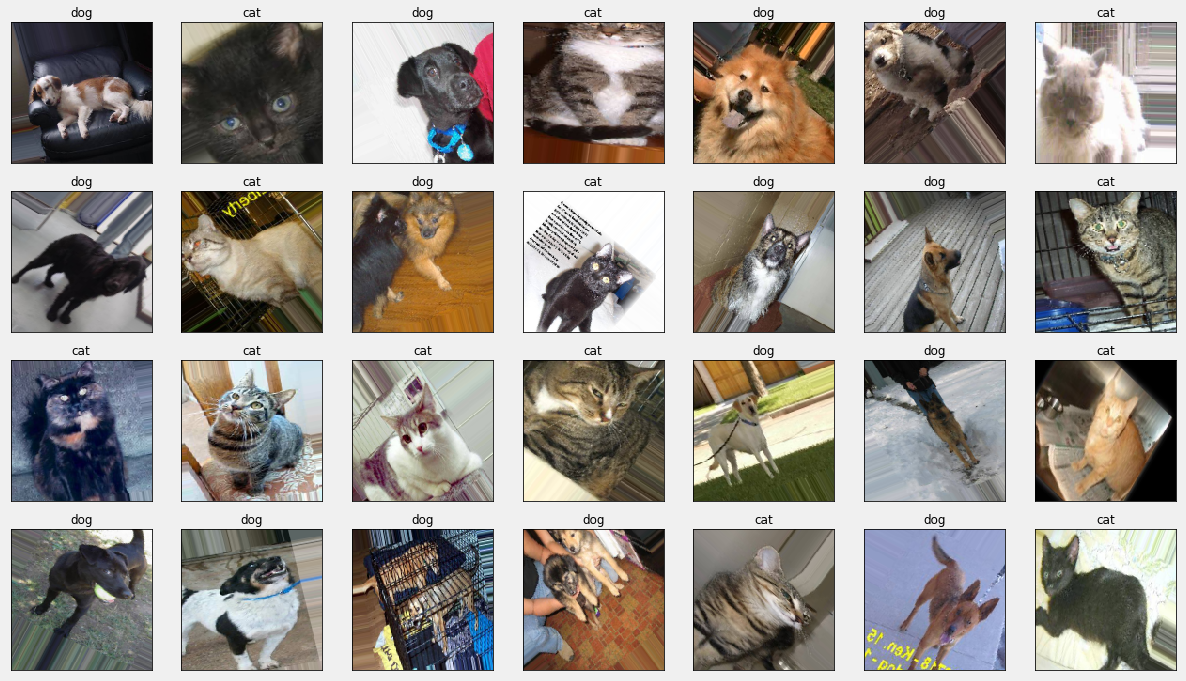

In [6]:
%matplotlib inline

# this line is needed to yield the batches from the top
train_generator.reset()

for images, labels in train_generator:    
    
    # show images
    show_batch_grid(images, labels)

    # we need this break, otherwise, the generator will yield images indefinitely
    break

Below, we review a few of the transformations.

In [54]:
# generator only
datagen_base = ImageDataGenerator(
                    rescale=1./255,             # we multiply the data by the value provided (after applying all other transformations)
                    )

generator_base = datagen_base.flow_from_directory(
                    train_dir,                  # target directory
                    target_size=(150, 150),     # resizes all images to (150, 150), they are still color images
                    batch_size=28,              # number of images on each batch
                    class_mode="binary",        # becuase you use binary_crossentropy, you need binary labels
                    seed=42,
                    )

Found 2000 images belonging to 2 classes.


In [56]:
def show_images_from_generator(generator):
    """
    Show images of the generator
    """

    # this line is needed to yield the batches from the top
    #generator.reset()
    
    print("batch_index", generator.batch_index)

    for images, labels in generator:    

        # show images
        show_batch_small_grid(images, labels)

        # we need this break, otherwise, the generator will yield images indefinitely
        break

### Rotation

In [57]:
# generator + transformation
datagen_trans = ImageDataGenerator(
                    rescale=1./255,             # we multiply the data by the value provided (after applying all other transformations)
                    rotation_range=90,          # int, degree range for random rotations
                    fill_mode="nearest",        # One of {"constant", "nearest", "reflect" or "wrap"}
                    )

generator_trans = datagen_trans.flow_from_directory(
                    train_dir,                  # target directory
                    target_size=(150, 150),     # resizes all images to (150, 150), they are still color images
                    batch_size=28,              # number of images on each batch
                    class_mode="binary",        # becuase you use binary_crossentropy, you need binary labels
                    seed=42,
                    )

Found 2000 images belonging to 2 classes.


no transformation
batch_index 2


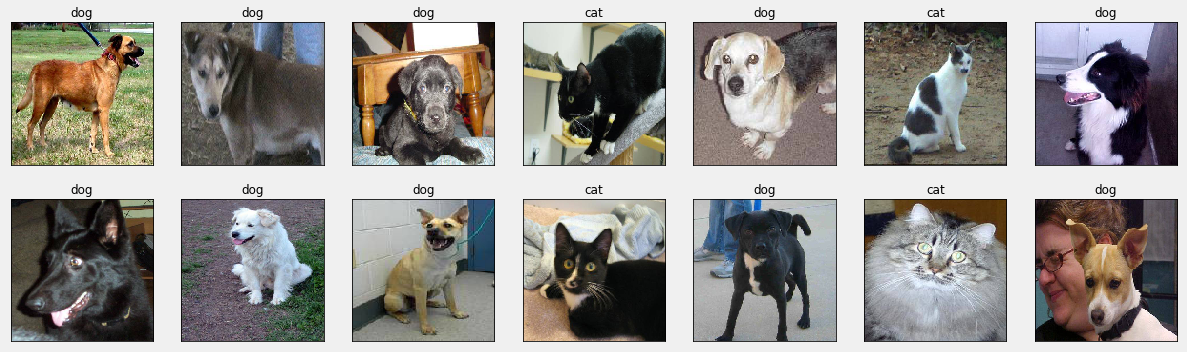

transformation
batch_index 2


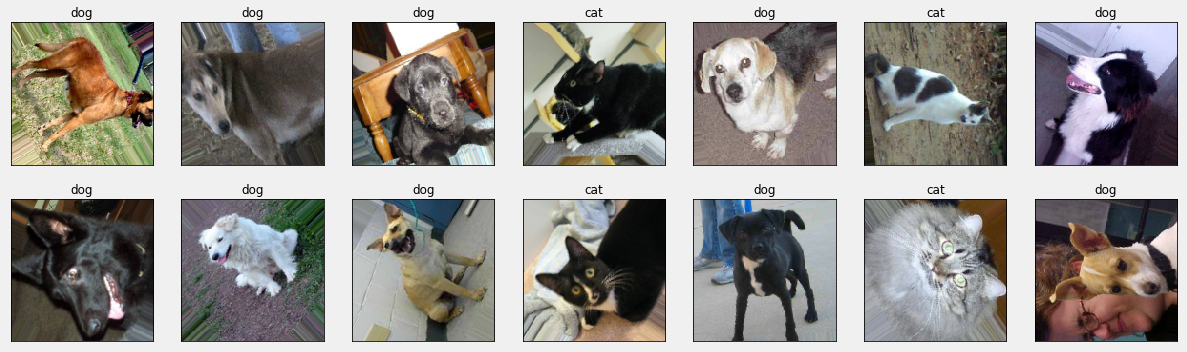

In [60]:
%matplotlib inline

print("no transformation")
show_images_from_generator(generator_base)

print("transformation")
show_images_from_generator(generator_trans)

In [50]:
continua con las demas transformaciones

2000

1